#Get data from bucket

**Imports**

In [ ]:
from google.colab import auth
from IPython.display import clear_output

**Authentication and Setup**

In [ ]:
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

**gcloud init**

1. "Pick configuration to use:" reply 1 (Re-initialize this configuration [default] with new settings)
2. Select relevant account and project
 

In [ ]:
!gcloud init
clear_output()
print("gcloud init complete, output cleared")

gcloud init complete, output cleared


**Download and Inflate Data**

In [ ]:
!gsutil cp gs://ganilla_bucket/data.zip .

Copying gs://ganilla_bucket/data.zip...
\ [1 files][261.0 MiB/261.0 MiB]                                                
Operation completed over 1 objects/261.0 MiB.                                    


In [ ]:
!gsutil cp -r gs://ganilla_bucket/models .

Copying gs://ganilla_bucket/models/ganilla_01.pt...
Copying gs://ganilla_bucket/models/ganilla_02.pt...
Copying gs://ganilla_bucket/models/ganilla_04.pt...
\ [3 files][689.0 MiB/689.0 MiB]   48.7 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://ganilla_bucket/models/ganilla_08.pt...
Copying gs://ganilla_bucket/models/ganilla_16.pt...
Copying gs://ganilla_bucket/models/ganilla_32.pt...
Copying gs://ganilla_bucket/models/ganilla_33.pt...
Copying gs://ganilla_bucket/models/ganilla_34.pt...
Copying gs://ganilla_bucket/models/ganilla_35.pt...
Copying gs://ganilla_bucket/models/ganilla_36.pt...
Copying gs://ganilla_bucket/models/ganilla_37.pt...
Copying gs://ganilla_bucket/models/ganilla_38.pt...
Copying gs://ganilla_bucket/models/ganilla_

In [ ]:
!ls #Verify files

adc.json  data.zip  models  sample_data


In [ ]:
!unzip data.zip

# Setup

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import itertools
from skimage import io
from PIL import Image, ImageOps, ImageDraw
import os
from google.colab import files

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import imageio

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
print("torch version:", torch.__version__)
print("cuda version" ,torch.version.cuda)

torch version: 1.10.0+cu111
cuda version 11.1


In [ ]:
NUM_TRAIN = 4
NUM_VAL = 3

NOISE_DIM = 96
batch_size = 1

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
    dtype = torch.cuda.FloatTensor
else:
    dev = "cpu"
    dtype = torch.FloatTensor
print(dev)

cuda:0


# Utils

In [ ]:
def show_images(images, transforms=[], is_torch=True, title=None):
    if is_torch:
        for t in transforms:
            images = [t(i) for i in images]
        images = [i.numpy().transpose((1, 2, 0)) for i in images]

    sqrtn = int(np.ceil(np.sqrt(len(images))))
    small_size = int(np.ceil(np.sqrt(images[0].shape[0]))) # 16
    sqrtimg = int(images[0].shape[0]) # 256
    n_channels = int(images[0].shape[-1]) # 3

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,n_channels]))
    if title is not None:
        plt.title(title) 
    return 

def save_images(images, file_name, transforms=[], is_torch=True):
    if is_torch:
        for t in transforms:
            images = [t(i) for i in images]
        images = [i.numpy().transpose((1, 2, 0)) for i in images]
    # print(f"my type {type(images[0])} ")
    im = Image.fromarray((images[0] * 255).astype(np.uint8))
    im.save(file_name + '.jpg')

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

# Dataset

In [ ]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

class GanillaDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir = 'data', dir_A = 'train_A', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.images = os.listdir(root_dir + "/" + dir_A)
        self.images = [filename for filename in self.images \
                       if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
        self.root_dir = root_dir
        self.dir_A = dir_A
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name_A = os.path.join(self.root_dir, self.dir_A, self.images[idx])
        image_A = Image.open(img_name_A).convert('RGB')
        image_A = ImageOps.fit(image_A, (256, 256), Image.ANTIALIAS)
        
        if self.transform:
          for t in self.transform:
            image_A = t(image_A)

        return image_A

In [ ]:
def scale_width(img, target_width):
    ow, oh = img.size

    # The size needs to be a multiple of this number, because going through 
    # generator network may change img size and cause a size mismatch error.
    mult = 4
    assert target_width % mult == 0, "the target width needs to be multiple of %d." % mult
    if (ow == target_width and oh % mult == 0):
        return img
    w = target_width
    target_height = int(target_width * oh / ow)
    m = (target_height - 1) // mult
    h = (m + 1) * mult
    
    return img.resize((w, h), Image.BICUBIC)

class ScaleWidth(torch.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, img):
        return scale_width(img, self.size)

# Main

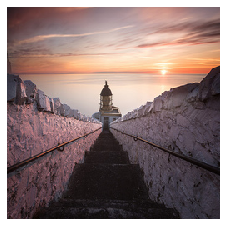

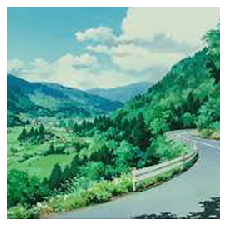

In [ ]:
# transform_list = [transforms.CenterCrop(256),
#                   ScaleWidth(256),
#                   transforms.ToTensor(),
#                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

inv_normalize = transforms.Normalize(mean=[-1, -1, -1],  std=[1/0.5, 1/0.5, 1/0.5])


train_ds_nature = GanillaDataset(root_dir="data/train", dir_A = 'nature', transform=transform_list)
train_ds_illustration = GanillaDataset(root_dir="data/train", dir_A = 'illustrations', transform=transform_list)

loader_train_nature = DataLoader(train_ds_nature, batch_size=batch_size, shuffle=True)
loader_train_illustration = DataLoader(train_ds_illustration, batch_size=batch_size, shuffle=True)

imgs_A = loader_train_nature.__iter__().next()
imgs_B = loader_train_illustration.__iter__().next()

show_images(imgs_A, [inv_normalize])
show_images(imgs_B, [inv_normalize]) 

# Model

In [ ]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
      super(PatchGANDiscriminator, self).__init__()

      self.model = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
          nn.InstanceNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
          nn.InstanceNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=True),
          nn.InstanceNorm2d(512),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=True),
          nn.Sigmoid()
      )


    def forward(self, input):
        return self.model(input)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_shortcut):
      super(ResidualBlock, self).__init__()
      self.shortcut = use_shortcut

      self.pad_1      = nn.ReflectionPad2d(1)
      self.conv_1     = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, bias=False)
      self.instance_1 = nn.InstanceNorm2d(out_channels)      
      self.relu_1     = nn.ReLU()

      self.pad_2      = nn.ReflectionPad2d(1)
      self.conv_2     = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, bias=False)
      self.instance_2 = nn.InstanceNorm2d(out_channels)
      
      # shourtcut
      self.conv_shortcut     = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False)
      self.instance_shortcut = nn.InstanceNorm2d(out_channels)

      # last 
      self.pad_last      = nn.ReflectionPad2d(1)
      self.conv_last     = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels, kernel_size=3, stride=1, bias=False)
      self.instance_last = nn.InstanceNorm2d(out_channels)
      self.relu_last     = nn.ReLU()
      

    def forward(self, input):
      # 1: pad, conv, norm, relu
      x_1 = self.pad_1(input)
      x_1 = self.conv_1(x_1)
      x_1 = self.instance_1(x_1)
      x_1 = self.relu_1(x_1)

      # 2: pad, conv, norm
      x_2 = self.pad_2(x_1)
      x_2 = self.conv_2(x_2)
      x_2 = self.instance_2(x_2)

      # shortcut: conv, norm
      if self.shortcut:
        x_short = self.conv_shortcut(input)
        x_short = self.instance_shortcut(x_short)
      else:
        x_short = input
      # concat
      x_concat = torch.cat((x_2, x_short),dim=1)

      # last: pad, conv, norm, relu
      x_last = self.pad_last(x_concat)
      x_last = self.conv_last(x_last)
      x_last = self.instance_last(x_last)
      result = self.relu_last(x_last)

      return result

In [ ]:
class Layer(nn.Module):
    def __init__(self, in_channels, out_channels, first_block_stride, use_shortcut):
        super(Layer, self).__init__()
        self.res1 = ResidualBlock(in_channels, out_channels, stride=first_block_stride, use_shortcut=use_shortcut)
        self.res2 = ResidualBlock(out_channels, out_channels, stride=1, use_shortcut=False)

    def forward(self, x):
        result = self.res1(x)
        result = self.res2(result)
        return result

class PreLayer(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
      # reference code: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
      super(PreLayer, self).__init__()
      self.pad_1      = nn.ReflectionPad2d(in_channels)
      self.conv1      = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=0, bias=True)
      self.instance_1 = nn.InstanceNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.dropout    = nn.Dropout(0.5)
      self.pad_2      = nn.ReflectionPad2d(1)
      self.max_pool   = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

    def forward(self, x):
      result = self.pad_1(x)
      result = self.conv1(result)
      result = self.instance_1(result)
      self.relu(result) #relu in-place
      result = self.dropout(result)
      result = self.pad_2(result)
      result = self.max_pool(result)
      return result

In [ ]:
class UplsamplingLayer(nn.Module):
  def __init__(self):
      super(UplsamplingLayer, self).__init__()
      self.conv_pre = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0, bias=True)

      self.upsampler_1 = nn.Upsample(scale_factor=2, mode='nearest')
      self.skip_conn_conv_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=True)
      #self.sum_1

      self.upsampler_2 = nn.Upsample(scale_factor=2, mode='nearest')
      self.skip_conn_conv_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=True)
      #self.sum_2

      self.upsampler_3 = nn.Upsample(scale_factor=2, mode='nearest')
      self.skip_conn_conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0, bias=True)
      #self.sum_3
      
      self.upsampler_post  = nn.Upsample(scale_factor=2, mode='nearest')
      self.pad_post  =  nn.ReflectionPad2d(1)
      self.conv_post = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)

      self.pad_out  =  nn.ReflectionPad2d(3)
      self.conv_out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0, bias=True)
      self.tanh_out = nn.Tanh()
  
  def forward(self, input_array):
      conv_pre = self.conv_pre(input_array[0])
      
      upsampler_1 = self.upsampler_1(conv_pre)
      skip_out_1  = self.skip_conn_conv_1(input_array[1])
      sum_1 = upsampler_1 + skip_out_1

      upsampler_2 = self.upsampler_2(sum_1)
      skip_out_2  = self.skip_conn_conv_2(input_array[2])
      sum_2 = upsampler_2 + skip_out_2

      upsampler_3 = self.upsampler_3(sum_2)
      skip_out_3  = self.skip_conn_conv_3(input_array[3])
      sum_3 = upsampler_3 + skip_out_3
      
      upsampler_post = self.upsampler_post(sum_3)
      pad_post = self.pad_post(upsampler_post)
      post_result = self.conv_post(pad_post)

      pad_out = self.pad_out(post_result)
      conv_out = self.conv_out(pad_out)
      tanh_out = self.tanh_out(conv_out)
      return tanh_out


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.pre_layer = PreLayer(in_channels=3 , out_channels=64)
    self.layer1 = Layer(in_channels=64,  out_channels=64,  first_block_stride=1, use_shortcut=False) 
    self.layer2 = Layer(in_channels=64,  out_channels=128, first_block_stride=2, use_shortcut=True)
    self.layer3 = Layer(in_channels=128, out_channels=128, first_block_stride=2, use_shortcut=True)
    self.layer4 = Layer(in_channels=128, out_channels=256, first_block_stride=2, use_shortcut=True)
    self.upsampler = UplsamplingLayer()

  def forward(self, x):
    result_pre = self.pre_layer(x)
    result_1 = self.layer1(result_pre)
    result_2 = self.layer2(result_1)
    result_3 = self.layer3(result_2)
    result_4 = self.layer4(result_3)
    result = self.upsampler([result_4, result_3, result_2, result_1])
    return result



In [ ]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = self.real_label if target_is_real else self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

In [ ]:
def init_weights(m, init_gain=0.02):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1 or (classname.find('BatchNorm2d') != -1)):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

In [ ]:
class GanillaModel():
    def __init__(self, path=None, train=True):
        self.epoch = 0
        self.lambda_nature = 10.0
        self.lambda_illustration = 10.0
        self.lambda_identity = 0.5
        self.betas = (0.001, 0.999)

        self.G_nature_illustration = Generator().to(dev)
        self.G_illustration_nature = Generator().to(dev)
        self.D_nature = PatchGANDiscriminator().to(dev)
        self.D_illustration = PatchGANDiscriminator().to(dev)
        
        for net in [self.G_nature_illustration, self.G_illustration_nature, self.D_nature, self.D_illustration]:
            net.apply(init_weights)

        # define loss functions
        self.generator_loss = GANLoss().to(dev)
        self.cycle_consistency_loss = torch.nn.L1Loss().to(dev)
        self.identity_loss = torch.nn.L1Loss().to(dev)
        self.discriminator_loss = GANLoss().to(dev)

        # From the GANILLA documentation: "We train our models for 200 epoch 
        #           using Adam solver with a learning rate of 0.0002."

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_nature_illustration.parameters(), 
                                                            self.G_illustration_nature.parameters()),
                                            lr=2e-4, betas=self.betas)
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.D_nature.parameters(), 
                                                            self.D_illustration.parameters()),
                                            lr=2e-4, betas=self.betas)
        
        if path:
          self.load(path)
          if train:
            for net in [self.G_nature_illustration, self.G_illustration_nature, self.D_nature, self.D_illustration]:
              if train:
                net.train()
              else:
                net.eval()           
        
    def forward(self, real_nature, real_illustration):
        self.real_illustration = real_illustration
        self.real_nature = real_nature
        
        self.fake_nature = self.G_illustration_nature(real_illustration)
        self.fake_illustration = self.G_nature_illustration(real_nature)

        self.identity_nature = self.G_illustration_nature(real_nature)
        self.identity_illustration = self.G_nature_illustration(real_illustration)

        self.cycled_nature = self.G_illustration_nature(self.fake_illustration)
        self.cycled_illustration = self.G_nature_illustration(self.fake_nature)
        
        
    def delete_forward_vars(self): 
        del self.real_illustration, self.real_nature, self.fake_nature
        del self.fake_illustration, self.identity_nature, self.identity_illustration
        del self.cycled_nature, self.cycled_illustration
        torch.cuda.empty_cache()

        

    def backward_G(self):
        self.optimizer_G.zero_grad()
        # Gan loss
        loss_g_nature = self.generator_loss(self.D_nature(self.fake_nature), True)
        loss_g_illustration = self.generator_loss(self.D_illustration(self.fake_illustration), True)

        # Cycle Consistency losses
        loss_cycled_nature = self.lambda_nature * self.cycle_consistency_loss(self.cycled_nature, self.real_nature)
        loss_cycled_illustration = self.lambda_illustration * self.cycle_consistency_loss(self.cycled_illustration, self.real_illustration)

        # Identity losses
        loss_identity_nature = self.lambda_identity * self.lambda_nature * self.identity_loss(self.identity_nature, self.real_nature)
        loss_identity_illustration = self.lambda_identity * self.lambda_illustration * self.identity_loss(self.identity_illustration, self.real_illustration)

        g_loss = loss_g_nature + loss_g_illustration + loss_cycled_nature + loss_cycled_illustration + loss_identity_nature + loss_identity_illustration
        g_loss.backward(retain_graph=True)

        self.optimizer_G.step()
    
    def backward_D(self):
        self.optimizer_D.zero_grad()
        # Gan loss
        loss_d_nature = self.discriminator_loss(self.D_nature(self.fake_nature), False) + self.discriminator_loss(self.D_nature(self.real_nature), True)
        loss_d_illustration = self.discriminator_loss(self.D_illustration(self.fake_illustration), False) + self.discriminator_loss(self.D_illustration(self.real_illustration), True)
        
        loss_d = 0.5*(loss_d_nature + loss_d_illustration)
        loss_d.backward(retain_graph=True)

        self.optimizer_D.step()
    
    def run_inferrence(self, inference_loader, to_illustration, save_image, model=''):
        generator = ganilla.G_nature_illustration if to_illustration else ganilla.G_illustration_nature
        title = 'generated_illustration' if to_illustration else 'generated_nature'
        title = title + '_' + model[-5:-3]
        for i, image in enumerate(inference_loader):
          show_images(image, [inv_normalize], title="original_image")
          generated_image = generator(image.to(dev))
          show_images(generated_image.detach().cpu(), [inv_normalize], title=title)
          if save_image:
                save_images(generated_image.detach().cpu(), f"{title}_{i}", [inv_normalize])  

    def run_inferrence_for_compare(self, inference_loader, to_illustration, save_image, model=None, dir=None):
        generator = ganilla.G_nature_illustration if to_illustration else ganilla.G_illustration_nature
        title = 'generated_illustration' if to_illustration else 'generated_nature'
        title = title + '_' + model[-5:-3] 
        for i, image in enumerate(inference_loader):
          generated_image = generator(image.to(dev))
          if save_image:
            file_path = os.path.join(dir, title)
            save_images(generated_image.detach().cpu(), f"{file_path}", [inv_normalize])  
            print(title + ' saved')
          else:
            show_images(generated_image.detach().cpu(), [inv_normalize], title=title)
          

    def show(self):
        show_images(self.real_nature.detach().cpu(), [inv_normalize], title="real_nature")
        show_images(self.real_illustration.detach().cpu(), [inv_normalize], title="real_illustration")
        show_images(self.fake_nature.detach().cpu(), [inv_normalize], title="fake_nature")
        show_images(self.fake_illustration.detach().cpu(), [inv_normalize], title="fake_illustration")

    def save(self, dir='.', save_with_epoch=True):
      file_name = f'ganilla_{self.epoch}.pt' if save_with_epoch else 'ganilla.pt'
      path = dir + "/" + file_name
      torch.save({
            'epoch': self.epoch,
            'model_Gni_state_dict': self.G_nature_illustration.state_dict(),
            'model_Gin_state_dict': self.G_illustration_nature.state_dict(),
            'model_Dn_state_dict': self.D_nature.state_dict(),
            'model_Di_state_dict': self.D_illustration.state_dict(),
            'optimizer_G_state_dict': self.optimizer_G.state_dict(),
            'optimizer_D_state_dict': self.optimizer_D.state_dict(),
            'loss_G': self.generator_loss,
            'loss_cc': self.cycle_consistency_loss,
            'loss_I': self.identity_loss,
            'loss_D': self.discriminator_loss
            }, path)

    def load(self, PATH='.'):
      checkpoint = torch.load(PATH)
      self.epoch = checkpoint['epoch']
      self.G_nature_illustration.load_state_dict(checkpoint['model_Gni_state_dict'])
      self.G_illustration_nature.load_state_dict(checkpoint['model_Gin_state_dict'])
      self.D_nature.load_state_dict(checkpoint['model_Dn_state_dict'])
      self.D_illustration.load_state_dict(checkpoint['model_Di_state_dict'])

      self.generator_loss = checkpoint['loss_G']
      self.cycle_consistency_loss = checkpoint['loss_cc']
      self.identity_loss = checkpoint['loss_I']
      self.discriminator_loss = checkpoint['loss_D']

      self.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
      self.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict']) 


In [ ]:
# for batch in loader_train:
#     # print(batch.shape)
#     net = Generator()
#     out_images = net(batch)
#     show_images(out_images.detach().numpy().transpose((0, 2, 3, 1)).astype('uint8'))

In [ ]:
# The loss function is comprised of:
# 1. minimax (will be used twice) 2. Identity loss 3. cycle consistency loss
def run_a_gan(ganilla, loader_train_nature, loader_train_illustration, num_epochs=10, show_every=500, 
              batch_size=128, noise_size=96, save_every_func=lambda x: False, models_dir="."):
    iter_count = 0
    for epoch in range(num_epochs):
        for x_nature, x_illustration in zip(loader_train_nature, loader_train_illustration):
            print(f"epoch = {epoch} | global epoch = {ganilla.epoch} | iter_count = {iter_count}")
            if len(x_nature) != batch_size:
                continue
            
            ganilla.forward(x_nature.to(dev), x_illustration.to(dev))
            ganilla.backward_D()
            ganilla.backward_G()

            if (iter_count % show_every == 0):
                print(epoch)
                ganilla.show()
                plt.show()

            ganilla.delete_forward_vars()

            iter_count += 1
        ganilla.epoch += 1

        if save_every_func(ganilla.epoch, 256):
          ganilla.save(models_dir, save_with_epoch=True)

In [ ]:
def is_n_power_of_two(n):
  return (n & (n-1) == 0) and n != 0

def save_every_epoch(n, max_n):
  return is_n_power_of_two(n) or (n%max_n)==0

#Run Model

In [ ]:
# ganilla = GanillaModel( './ganilla.pt') # Load pre-trained model.
ganilla = GanillaModel()

KeyboardInterrupt: ignored

In [ ]:
run_a_gan(ganilla, loader_train_nature, loader_train_illustration, num_epochs=1000 , show_every=100, batch_size=batch_size, 
          save_every_func=save_every_epoch, models_dir="drive/MyDrive/ProjectFolder/Models")

#Run Inference On Uploaded Image

In [ ]:
if not os.path.isdir('data/test/uploaded'):
  !mkdir data/test/uploaded
if not os.path.isdir('genrated_images'):
  !mkdir genrated_images

Upload Image

In [ ]:
uploaded = files.upload()
for uploaded_file in uploaded.keys():
  curr_image_dir = uploaded_file[0 : uploaded_file.index('.')]
  !mkdir genrated_images/$curr_image_dir
  !mv $uploaded_file "data/test/uploaded/"$uploaded_file

Saving Maya_cloud.jpeg to Maya_cloud.jpeg


Select Which Models To Run

In [ ]:
models_list = []
for model in os.listdir('models'):
  models_list.append(model)
models_list.sort()  
print('Available models', models_list)
models_list_short = []
models_list_short.append(models_list[0])
models_list_short.append(models_list[3])
models_list_short.append(models_list[5])
models_list_short.append(models_list[7])
models_list_short.append(models_list[8])
models_list_short.append(models_list[9])
print('models_list_short', models_list_short)


Available models ['ganilla_01.pt', 'ganilla_02.pt', 'ganilla_04.pt', 'ganilla_08.pt', 'ganilla_16.pt', 'ganilla_32.pt', 'ganilla_33.pt', 'ganilla_34.pt', 'ganilla_35.pt', 'ganilla_36.pt', 'ganilla_37.pt', 'ganilla_38.pt', 'ganilla_39.pt', 'ganilla_40.pt', 'ganilla_41.pt', 'ganilla_42.pt', 'ganilla_43.pt', 'ganilla_44.pt', 'ganilla_45.pt', 'ganilla_50.pt', 'ganilla_55.pt']
models_list_short ['ganilla_01.pt', 'ganilla_08.pt', 'ganilla_32.pt', 'ganilla_34.pt', 'ganilla_35.pt', 'ganilla_36.pt']


Run Inference On Uploaded Image

genrated_images/Maya_cloud
generated_illustration_01 saved
generated_illustration_08 saved
generated_illustration_32 saved
generated_illustration_34 saved
generated_illustration_35 saved
generated_illustration_36 saved


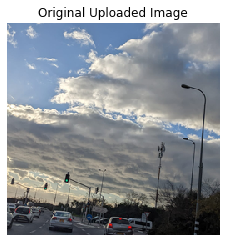

In [ ]:
uploaded_ds_nature  = GanillaDataset(root_dir="data/test/", dir_A = 'uploaded', transform=transform_list)
loader_uploaded_ds_nature = DataLoader(uploaded_ds_nature , batch_size=batch_size, shuffle=True)
imgs_uploaded = loader_uploaded_ds_nature.__iter__().next()
show_images(imgs_uploaded, [inv_normalize],title="Original Uploaded Image")

generated_dir = os.path.join('genrated_images', curr_image_dir)

for model in models_list_short:
  ganilla = GanillaModel('./models/'+model) # Load pre-trained model.
  inference_loader = DataLoader(uploaded_ds_nature, batch_size=1, shuffle=False)
  ganilla.run_inferrence_for_compare(inference_loader, True, True, model=model, dir=generated_dir)

Generate gif From Generated Images

In [ ]:
images_for_gif = []
for filename in os.listdir(generated_dir):
    images_for_gif.append(imageio.imread(os.path.join(generated_dir,filename)))
imageio.mimsave(curr_image_dir + '.gif', images_for_gif, duration=1.2)


#Run Inference On Test Images

In [ ]:
model_path = './models/ganilla_45.pt'
ganilla = GanillaModel(model_path) # Load pre-trained model.
val_ds = GanillaDataset(root_dir="data/test/", dir_A = 'nature', transform=transform_list)
inference_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
ganilla.run_inferrence(inference_loader, True, True, model_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
!ls -l ganilla.pt --block-size=MB

ls: cannot access 'ganilla.pt': No such file or directory
